 In this task we have two groups, identified by 2-d coordinates, and we have to determine an equation for a linear  separator for these   two groups of points. 
 Let's start with importing some necessary packages generally used when solving  classification problems:

In [632]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.optimize import linprog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from matplotlib.colors import ListedColormap

The groups are:

In [633]:
group1l = [[0.067, 0.21], [0.092, 0.21], 
  [0.294, 0.445], [0.227, 0.521], [0.185, 0.597], 
  [0.185, 0.689], [0.235, 0.748], [0.319, 0.773], 
  [0.387, 0.739], [0.437, 0.672], [0.496, 0.739],
  [0.571, 0.773], [0.639, 0.765], [0.765, 0.924],
  [0.807, 0.933], [0.849, 0.941]]

group2l = [[0.118, 0.143], [0.118, 0.176], 
  [0.345, 0.378], [0.395, 0.319], [0.437, 0.261],
  [0.496, 0.328], [0.546, 0.395], [0.605, 0.462],
  [0.655, 0.529], [0.697, 0.597], [0.706, 0.664],
  [0.681, 0.723], [0.849, 0.798], [0.857, 0.849],
  [0.866, 0.899]]


Then we can convert the lists  in arrays and visualize the data in order to understand our data set:

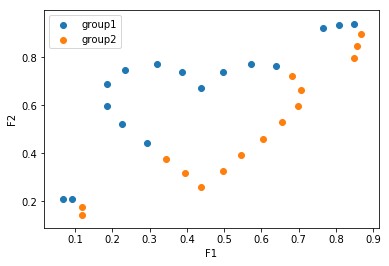

In [634]:
group1=np.array(group1l)
group2=np.array(group2l)

plt.figure(1)  
plt.scatter(group1[:,0], group1[:,1], label='group1')
plt.scatter(group2[:,0], group2[:,1], label='group2')
plt.xlabel('F1')  #first feature
plt.ylabel('F2') #second feature
plt.legend()


At a first look, the two groups look separable by a line.
We can also use a Convex Hull to check if the classes are linearly separable (i.e., if the intersection of the convex hulls of group1 and group2 is empty).

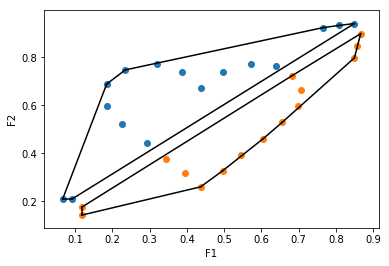

In [635]:
hull1 = ConvexHull(group1)
hull2 = ConvexHull(group2)


plt.figure(2)  
plt.scatter(group1[:,0], group1[:,1])
plt.scatter(group2[:,0], group2[:,1])
plt.xlabel('F1')
plt.ylabel('F2')
for simplex in hull1.simplices:
    plt.plot(group1[simplex, 0], group1[simplex, 1], 'k-')

for simplex in hull2.simplices:
    plt.plot(group2[simplex, 0], group2[simplex, 1], 'k-')

From the visual representation of the convex hulls we can conclude that it seems possible to linearly separate the two groups (empty intersection).
We can now use some machine learning classifier to perform the linear separation.

First of all we can build a dataframe to indentify predictors (x) and target (y) more clearly.
We want to perform a binary classification, so we assign a target value of 1 to group1 and 0 to group2.

We will apply our classifiers on the entire data set without dividing in test/train since we need to find the equation of a linear separator among two classes, and not to build a model for future predictions.


In [636]:
#data dictionary
data = {'data': np.vstack((group1,group2)), 'target': np.vstack((np.ones([16,1]),np.zeros([15,1]))), 'features_name': ['F1', 'F2'] }

#dataframe
df = pd.DataFrame(data['data'], columns=data['features_name'])
df['Target'] = pd.DataFrame(data['target'])
x = df[['F1', 'F2']].values #predictors
y=df['Target'].values #target

We can first scale our features.

We can then apply the Single Layer Perceptron as first binary classifier. 
A single layer perceptron will  converge if the two classes are linearly separable (we will have correct classification).
We can also obtain the weights and plot the obtained equation for the line separator (for a perceptron with a 2-dimensional input vector, we need to use weights and bias into the standard form equation of a line).



weights: 
[[-4.27933705  4.24869177]]
Intercept: 
[1.]


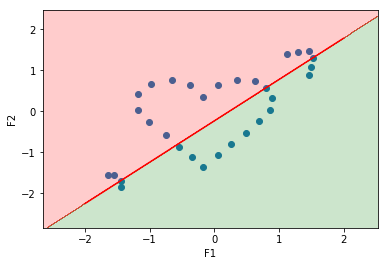

In [637]:
#features scaling
sc= StandardScaler()
x = sc.fit_transform(x)

#build model
perceptron = Perceptron(tol=1e-3, random_state=0)
perceptron.fit(x, y)
predicted = perceptron.predict(x)

#
print('weights: ')
print(perceptron.coef_)
print('Intercept: ')
print(perceptron.intercept_)
#

#Plot our data
plt.figure(5)
plt.scatter(x[:,0], x[:,1])
plt.xlabel('F1')
plt.ylabel('F2')

X_set, y_set = x, y
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, perceptron.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.2, cmap = ListedColormap(('green', 'red')))


# Create the separator
w = perceptron.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-2, 2)
yy = a * xx - (perceptron.intercept_[0]) / w[1]

# Plot the separator
plt.plot(xx, yy, 'r-')



In order to evaluate the goodness of our classification we can build the confusion matrix.
We can see that all the points are correctly classified and therefore we can conclude that we obtained a good decision boundary.

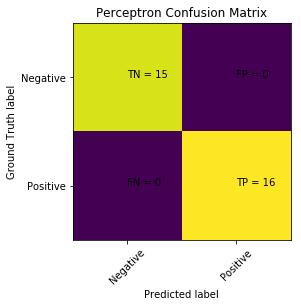

In [638]:
#predicted value:

predicted = perceptron.predict(x)
cm = confusion_matrix(y, predicted)
 
plt.clf() 
plt.imshow(cm, interpolation='nearest')
classNames = ['Negative','Positive']
plt.title('Perceptron Confusion Matrix')
plt.ylabel('Ground Truth label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
  
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

As second method, we can  try support vector machines (SVM) with a linear kernel.  Parameter C is tuned to have the minimum misclassification error.
Linear support vector machines (SVM) aim at finding the hyperplanes separating the two data classes with the largest margin possible. The hyperplane is defined by
w · x - b = 0
where w is the normal vector of the hyperplane, x the feature vector, and b a parameter co-defining the hyperplane.


In [639]:
#SVM classifier
clf = SVC(kernel='linear', C=200)
clf.fit(x, y)

SVC(C=200, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In order to get the equation of the separator we can use the coefficients (weights and bias) from the classifier ouput. We can also plot our separating plane:

weights: 
[[-8.69073462  8.64647906]]
Intercept: 
[1.03515279]


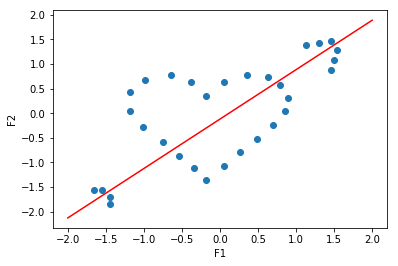

In [640]:
print('weights: ')
print(clf.coef_)
print('Intercept: ')
print(clf.intercept_)

 
# Plot data points 
plt.figure(3)
plt.scatter(x[:,0], x[:,1])
plt.xlabel('F1')
plt.ylabel('F2')

# Create the hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-2, 2)
yy = a * xx - (clf.intercept_[0]) / w[1]

# Plot the hyperplane
plt.plot(xx, yy, 'r-')

The confusion matrix is again helpful to make sure we have correct classification. We can see that we do not have any misclassification (perfect separation).

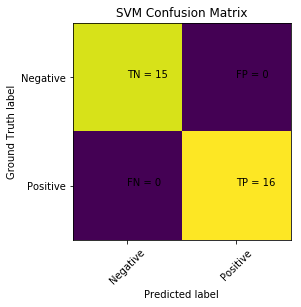

In [641]:
predicted = clf.predict(x)
 
cm = confusion_matrix(y, predicted)

plt.figure(4)
plt.imshow(cm, interpolation='nearest')
classNames = ['Negative','Positive']
plt.ylabel('Ground Truth label')
plt.xlabel('Predicted label')
plt.title('SVM Confusion Matrix')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))

The last classifier we can try is logistic regression. We follow the same procedure:

weights: 
[[-1.74565861  1.78696573]]
Intercept: 
[0.15709525]


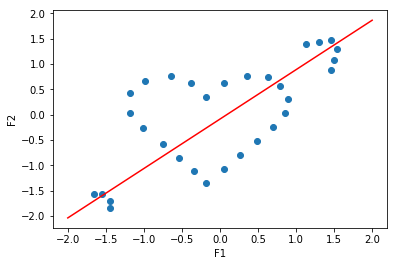

In [642]:
logmodel = LogisticRegression(random_state=0, solver='lbfgs')
logmodel.fit(x,y)
print('weights: ')
print(logmodel.coef_)
print('Intercept: ')
print(logmodel.intercept_)

 
# Plot data points 
plt.figure(5)
plt.scatter(x[:,0], x[:,1])
plt.xlabel('F1')
plt.ylabel('F2')

# Create the hyperplane
w = logmodel.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-2, 2)
yy = a * xx - (logmodel.intercept_[0]) / w[1]

# Plot the hyperplane
plt.plot(xx, yy, 'r-')
    

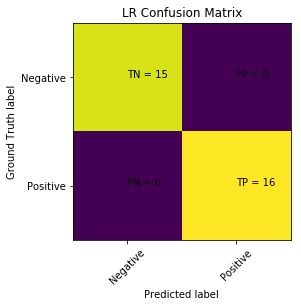

In [643]:
predictedr = logmodel.predict(x)
 
cmr = confusion_matrix(y, predictedr)

plt.figure(6)
plt.imshow(cmr, interpolation='nearest')
classNames = ['Negative','Positive']
plt.ylabel('Ground Truth label')
plt.xlabel('Predicted label')
plt.title('LR Confusion Matrix')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cmr[i][j]))

We can conclude that the linear separability of the two sets has been investigates.
Perfect separation obtained with different machine learining methods indicates  linear separability.